## Good activation-clamp = good target-source gradient alignment ?

Here we perform three experiments:
1. Gradient alignment vs. standard linear regression EV as a function of sample size
2. Original strech/OHP control objective vs. gradient alignment EV from linear mapping
3. New vector control objective vs. gradient alignment EV. 

The goal of #1 is to see whether better pointwise function alignment leads to better gradient alignment.
If this is not the case, then this would explan #2. Given these observations we improve upon the control metric's sensitivity to gradient with #3.

In [1]:
import torch
import torchvision.models as models
from util.modelregressions import CNNCrossFit
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
# load up target and source models
squeezenet_target = models.squeezenet1_1(pretrained=True).features
squeezenet_source = models.squeezenet1_0(pretrained=True).features
# define basic params 
cnn_layer = 12
source_units = np.arange(512)
target_units = np.arange(100)
# pre-load data into memory for speed
n_data = 5000;
n_train = 4000;
n_test = 1000;
hvmdataset = HVMDataset('cpu',n_data)

loading and preprocessing hvm


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 199.22it/s]


In [3]:
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,cnn_layer,target_units,source_units,device)
# extract layer activation across two models
snet2snet.design(hvmdataset, batch_size = 10)

Extracting activations


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.23it/s]


In [ ]:
# train test split
snet2snet.train_test_split(n_train,n_test)
# linear prediction of target unit, record performance
snet2snet.fit()

Linear regression from source to target:


  1%|▊                                                                               | 1/100 [00:47<1:18:05, 47.33s/it]

In [5]:
# make a surrogate
snet2snet.get_surrogate()
# score the surrogate over test set
snet2snet.score(metric = 'EV')

Calculating test score:


100%|██████████████████████████████████████████████████████████████████████████| 22500/22500 [00:18<00:00, 1228.08it/s]


In [6]:
# projected A-clamp
eps = 10
snet2snet.vector_control(epsilon = eps, n_sets = 100, set_size = 50, lr = .001, wd = 1e-4, n_iter = 20)

Optimizing projected A-clamp over surrogate network:


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [12:21:06<00:00, 96.94s/it]


In [7]:
# scalar control
#eps = 10
#snet2snet.scalar_control(epsilon = eps, n_units = 10, lr = .001, wd = 1e-5, n_iter = 20)

In [8]:
# score the qualtiy of control
snet2snet.vec_control_score()

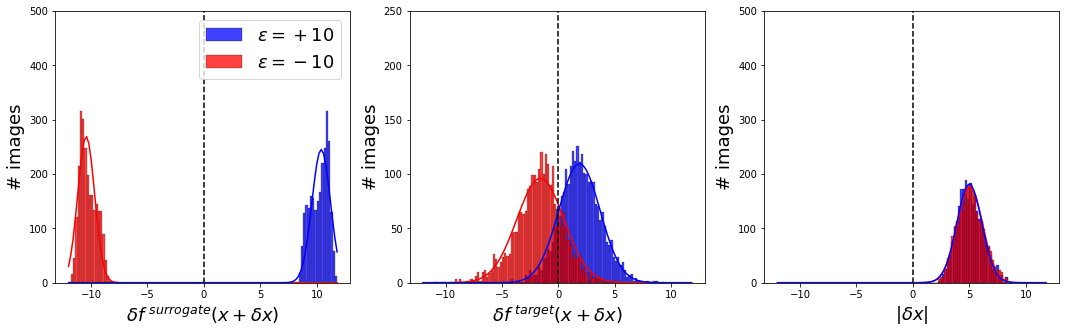

In [27]:
import seaborn as sns

gaussfit = lambda x,mu,sig: 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
xdelta = .2
xbin = np.arange(-eps-2,eps+2,xdelta)

samp_unit = [0]
# show example of single neuron activity clamp
plt.figure(figsize=(18,5))
pidx = snet2snet.sur_eps.cpu().numpy()[:,samp_unit[0]]>0
nidx = snet2snet.sur_eps.cpu().numpy()[:,samp_unit[0]]<0
p_sur_obs = snet2snet.sur_obs.cpu().numpy()[pidx,samp_unit[0]]
n_sur_obs = snet2snet.sur_obs.cpu().numpy()[nidx,samp_unit[0]]
ax1 = plt.subplot(1,3,1)
sns.histplot(p_sur_obs,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_sur_obs,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_sur_obs),np.std(n_sur_obs))*len(p_sur_obs)*.2,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_sur_obs),np.std(p_sur_obs))*len(p_sur_obs)*.2,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.ylim((0,n_data/10))
plt.xlabel(r'$\delta f^{\ surrogate}(x+\delta x)$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)
plt.legend(fontsize = 18)

p_tar_obs = snet2snet.tar_obs.cpu().numpy()[pidx,samp_unit[0]]
n_tar_obs = snet2snet.tar_obs.cpu().numpy()[nidx,samp_unit[0]]
ax2 = plt.subplot(1,3,2)
sns.histplot(p_tar_obs,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_tar_obs,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_tar_obs),np.std(n_tar_obs))*len(p_tar_obs)*.2,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_tar_obs),np.std(p_tar_obs))*len(p_tar_obs)*.2,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.ylim((0,n_data/20))
plt.xlabel(r'$\delta f^{\ target}(x+\delta x)$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)

p_dx = snet2snet.dx[pidx,samp_unit[0]]
n_dx = snet2snet.dx[nidx,samp_unit[0]]
ax1 = plt.subplot(1,3,3)
sns.histplot(p_dx,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_dx,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_dx),np.std(n_dx))*len(p_sur_obs)*.2,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_dx),np.std(p_dx))*len(p_sur_obs)*.2,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.ylim((0,n_data/10))
plt.xlabel(r'$|\delta x|$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)
plt.show()

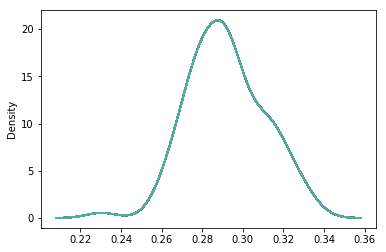

In [25]:
for i in range(100):
    sns.kdeplot(snet2snet.train_ctr_score)
plt.show()

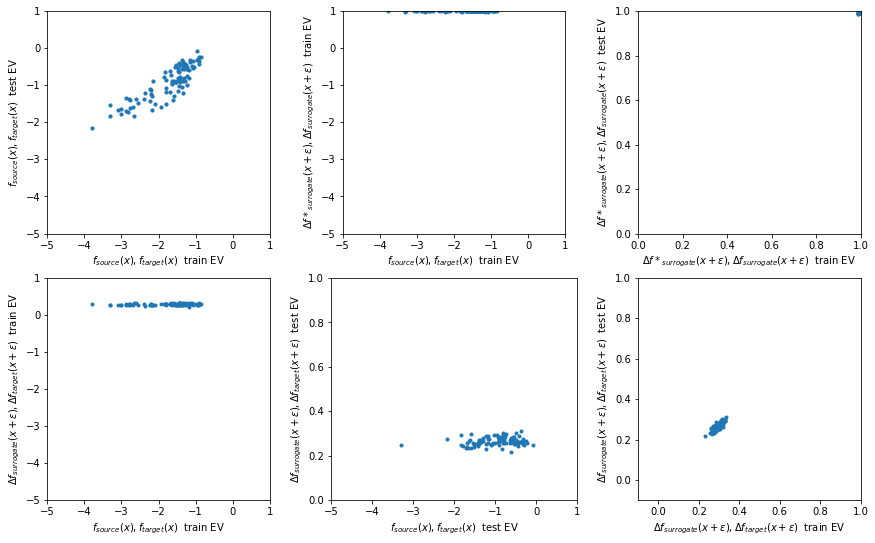

In [26]:
plt.figure(figsize=(15,9))
ax1 = plt.subplot(2,3,1)
ax1.set_aspect('equal')
plt.scatter(snet2snet.train_sub_score,snet2snet.test_sub_score,s=10)
plt.xlim([-5,1])
plt.ylim((-5,1))
plt.xlabel(r'${f_{source}(x),f_{target}(x)}$  train EV', fontsize=10)
plt.ylabel(r'${f_{source}(x),f_{target}(x)}$  test EV', fontsize=10)
ax2 = plt.subplot(2,3,2)
ax2.set_aspect('equal')
plt.plot(snet2snet.train_sub_score,snet2snet.train_sur_score,'.')
plt.xlim([-5,1])
plt.ylim([-5,1])
plt.xlabel(r'${f_{source}(x),f_{target}(x)}$  train EV', fontsize=10)
plt.ylabel(r'${\Delta f*_{surrogate}(x+\epsilon),\Delta f_{surrogate}(x+\epsilon)}$  train EV', fontsize=10)
ax3 = plt.subplot(2,3,3)
ax3.set_aspect('equal')
plt.plot(snet2snet.train_sur_score,snet2snet.test_sur_score,'.')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel(r'${\Delta f*_{surrogate}(x+\epsilon),\Delta f_{surrogate}(x+\epsilon)}$  train EV', fontsize=10)
plt.ylabel(r'${\Delta f*_{surrogate}(x+\epsilon),\Delta f_{surrogate}(x+\epsilon)}$  test EV', fontsize=10)
ax4 = plt.subplot(2,3,4)
ax4.set_aspect('equal')
plt.plot(snet2snet.train_sub_score,snet2snet.train_ctr_score,'.')
plt.xlim([-5,1])
plt.ylim((-5,1))
plt.xlabel(r'${f_{source}(x),f_{target}(x)}$  train EV', fontsize=10)
plt.ylabel(r'${\Delta f_{surrogate}(x+\epsilon),\Delta f_{target}(x+\epsilon)}$  train EV', fontsize=10)
ax5 = plt.subplot(2,3,5)
#ax5.set_aspect('equal')
plt.plot(snet2snet.test_sub_score,snet2snet.test_ctr_score,'.')
plt.xlim([-5,1])
plt.ylim([0,1])
plt.xlabel(r'${f_{source}(x),f_{target}(x)}$  test EV', fontsize=10)
plt.ylabel(r'${\Delta f_{surrogate}(x+\epsilon),\Delta f_{target}(x+\epsilon)}$  test EV', fontsize=10)
ax6 = plt.subplot(2,3,6)
ax6.set_aspect('equal')
plt.plot(snet2snet.train_ctr_score,snet2snet.test_ctr_score,'.')
plt.xlim([-.1,1])
plt.ylim((-.1,1))
plt.xlabel(r'${\Delta f_{surrogate}(x+\epsilon),\Delta f_{target}(x+\epsilon)}$  train EV', fontsize=10)
plt.ylabel(r'${\Delta f_{surrogate}(x+\epsilon),\Delta f_{target}(x+\epsilon)}$  test EV', fontsize=10)
plt.show()

In [12]:
loadd = 'snet10_snet11_512to100_'
gradalignment = np.loadtxt('params\\' + loadd + 'grad_alignement.csv',delimiter = ',')

C:\Users\Chong Guo\AppData\Local\conda\conda\envs\torch\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

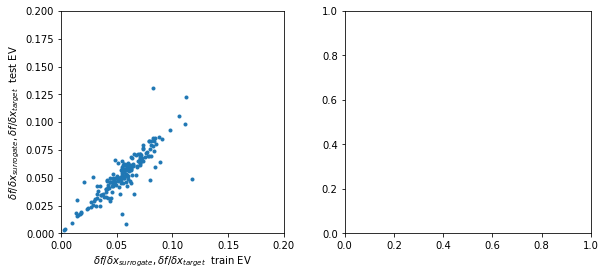

In [13]:
plt.figure(figsize=(15,9))
ax1 = plt.subplot(2,3,1)
ax1.set_aspect('equal')
plt.plot(np.nanmedian(gradalignment[:4000],axis=0).T,np.nanmedian(gradalignment[-1000:],axis=0).T,'.')
plt.xlim([0,.2])
plt.ylim((0,.2))
plt.xlabel(r'${\delta f/\delta x _{surrogate},\delta f/\delta x _{target}}$  train EV', fontsize=10)
plt.ylabel(r'${\delta f/\delta x _{surrogate},\delta f/\delta x _{target}}$  test EV', fontsize=10)
ax2 = plt.subplot(2,3,2)
plt.plot(np.nanmedian(gradalignment[-1000:],axis=0).T,snet2snet.test_ctr_score,'.')
plt.xlim([0,.2])
plt.ylim((0,1))
plt.xlabel(r'${\delta f/\delta x _{surrogate},\delta f/\delta x _{target}}$  test EV', fontsize=10)
plt.ylabel(r'${\Delta f_{surrogate}(x+\epsilon),\Delta f_{target}(x+\epsilon)}$  test EV', fontsize=10)
plt.show()

In [ ]:
plt.figure(figsize=(15,9))
ax1 = plt.subplot(2,3,1)
plt.imshow(np.transpose(g0[1],(1,2,0)))
plt.title(r'${\delta f/\delta x _{surrogate}}$')
ax2 = plt.subplot(2,3,2)
plt.imshow(np.transpose(g1[1],(1,2,0)))
plt.title(r'${\delta f/\delta x _{target}}$')
ax1 = plt.subplot(2,3,4)
plt.imshow(np.transpose(g0[9],(1,2,0)))
plt.title(r'${\delta f/\delta x _{surrogate}}$')
ax2 = plt.subplot(2,3,5)
plt.imshow(np.transpose(g1[9],(1,2,0)))
plt.title(r'${\delta f/\delta x _{target}}$')
plt.show()

In [ ]:
plt.figure(figsize=(15,9))
ax1 = plt.subplot(2,3,1)
plt.imshow(np.transpose(g0[1],(1,2,0)))
plt.title(r'${\delta f/\delta x _{surrogate}}$')
ax2 = plt.subplot(2,3,2)
plt.imshow(np.transpose(g1[1],(1,2,0)))
plt.title(r'${\delta f/\delta x _{target}}$')
ax1 = plt.subplot(2,3,4)
plt.imshow(np.transpose(g0[4],(1,2,0)))
plt.title(r'${\delta f/\delta x _{surrogate}}$')
ax2 = plt.subplot(2,3,5)
plt.imshow(np.transpose(g1[4],(1,2,0)))
plt.title(r'${\delta f/\delta x _{target}}$')
plt.show()

In [ ]:
plt.plot(np.nanmedian(np.nanmedian(snet2snet.train_score,axis=1),axis=1))
plt.imshow()

In [ ]:
from util.misc_functions import indexfun
import numpy as np
X = np.random.rand(40,10,10)
indexer = indexfun((10,10),np.arange(0,20,2))
np.transpose(X,(1,2,0))[indexer.get_sur([0,1])].shape

In [ ]:
X[tuple([[0,1,2],0,0])], X[0:3,0,0]

In [ ]:
import random
random.sample(range(0,10),min(21,10))

In [ ]:
np.array([1,2,2])*np.array([1,2,2])

In [ ]:
plt.plot((torch.clamp(snet2snet.Xsor[:,:3,5,5]+snet2snet.sur_eps.cpu(),min=0)-snet2snet.Xsor[:,:3,5,5]).numpy(),'.')
plt.show()

In [ ]:
plt.scatter(snet2snet.Xsur[:,1,5,5].numpy(),snet2snet.Xsur[:,0,5,5].numpy())
plt.show()

In [ ]:
for u, unit_id in enumerate(snet2snet.clamp_unit_id):
    index = snet2snet.indexer.get_sur(unit_id)
    snet2snet.test_sub_score[u] = snet2snet.test_score[index]

In [ ]:
# save the numbers
#np.savetxt('params/snet10_snet11_512to200_weights.csv', snet2snet.w, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_bias.csv', snet2snet.b, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_clamp_unit_id.csv', snet2snet.clamp_unit_id, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_grad_alignement.csv', gradalignment, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_sur_obs.csv', snet2snet.sur_obs, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_tar_obs.csv', snet2snet.tar_obs, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_set_id.csv', snet2snet.set_id, delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_sur_vobs.csv', snet2snet.sur_obs.cpu().numpy(), delimiter=",")
#np.savetxt('params/snet10_snet11_512to200_tar_vobs.csv', snet2snet.tar_obs.cpu().numpy(), delimiter=",")

In [ ]:
loadd = 'snet10_snet11_512to100_'
sv = np.loadtxt('params\\' + loadd + 'sur_obs.csv',delimiter = ',')
tv = np.loadtxt('params\\' + loadd + 'tar_obs.csv',delimiter = ',')
clampid = np.loadtxt('params\\' + loadd + 'clamp_unit_id.csv',delimiter = ',')

In [ ]:
import seaborn as sns
for i in range(100):
    sns.kdeplot(gradalignment[:,i])
plt.show()

In [ ]:
test_score = np.empty(200)
for u in range(200):
    test_score[u] = snet2snet.test_score[snet2snet.indexer.get_sur(int(clampid[u]))]

In [ ]:
plt.plot(test_score,np.nanmedian(gradalignment,axis=0),'.')
plt.xlim([-.5,1])
plt.ylim([0,.2])
plt.ylabel(r'${\delta f/\delta x _{surrogate},\delta f/\delta x _{target}}$  test EV', fontsize=10)
plt.xlabel(r'${f_{source}(x),f_{target}(x)}$  test EV', fontsize=10)
plt.show()

In [ ]:
gradalignment.shape

In [ ]:
f0[:,sur_index[0],sur_index[1],sur_index[2]]

In [ ]:
plt.imshow(x1_batch.grad.data[4].permute(1,2,0))

In [ ]:
x0 = x0_batch[8].detach().clone().to(device)
x0.requires_grad = True
x1 = x1_batch[4].detach().clone().to(device)
x1.requires_grad = True
f0 = snet2snet.surrogate_net.forward(x0.unsqueeze(0))
l0 = f0[:,sur_index[0],sur_index[1],sur_index[2]].sum()*1000
f1 = snet2snet.target_net.forward(x1.unsqueeze(0))
l1 = f1[:,sur_index[0],sur_index[1],sur_index[2]].sum()*1000
l0.backward()
l1.backward()
plt.subplot(1,2,1)
plt.imshow(x0.grad.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(x1.grad.permute(1,2,0))

In [ ]:
plt.imshow(x1.grad.permute(1,2,0)-x0.grad.permute(1,2,0))